<a href="https://colab.research.google.com/github/EliasSf73/test_/blob/master/Ensemble_ResNet%2C_implemmentation_and_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble_ResNets



&nbsp;



* **Part 1. Dataset visualization**
* **Part 2. Implement Building Blocks for ResNet**
* **Part 3. Implement variants of ResNet
* **Part 4. Train and visualize the results**
* **Part 5. Achieve the highest possible accuracy score.**


&nbsp;





In [2]:
# Importing the Required Library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# **Part 1**. Download and examine the CIFAR-10 dataset
- In this project, we'll use the CIFAR-10 dataset, which consists of 32x32x3  images of 10 classes.
- We'll download the dataset and examine its structure.

***Let's compute the means and standard deviations for the transformation***

In [3]:


# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

# Calculate mean and std
data = next(iter(trainloader))[0]  # get all data in one batch
means = data.mean(dim=[0, 2, 3])
stds = data.std(dim=[0, 2, 3])
print("Means: ", means)
print("Stds: ", stds)


100%|██████████| 170498071/170498071 [00:02<00:00, 75825450.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Means:  tensor([0.4914, 0.4822, 0.4465])
Stds:  tensor([0.2470, 0.2435, 0.2616])


In [4]:
# Define the transformation to be applied to the data
# Here, we are converting PIL Images or NumPy ndarrays to PyTorch Tensors
# and scaling the image pixel intensity values to the range [0., 1.]
transformations = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

# Download the FashionMNIST dataset for training and testing
# The transform defined above is applied to each item in the dataset
# train_dataset = datasets.CIFAR-10(root='./data', train=True, download=True, transform=transformations)
train_dataset = datasets.CIFAR10('./data', download=True, train=True, transform=transformations)
test_dataset = datasets.CIFAR10('./data', download=True, train=False, transform=transformations)

# Function to create DataLoader with a subset of the training dataset
def get_train_loader():
  # Generate a list of indices from 0 to the length of the training dataset
  indices = list(range(len(train_dataset)))
  # Calculate one-third of the dataset size for creating a smaller subset
  sub_dataset_size = len(train_dataset) // 3
  # Shuffle the indices
  random_indices = torch.randperm(len(indices)).tolist()
  # Select a subset of indices for the reduced dataset
  subset_indices = random_indices[:sub_dataset_size]

  # Create a subset of the training dataset using the selected indices
  train_subset = Subset(train_dataset, subset_indices)
  # Create a DataLoader for the subset of training data
  # with a batch size of 64 and shuffling enabled
  train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

  return train_loader

# Get the training DataLoader with subset of data
train_loader = get_train_loader()
# Create a DataLoader for the testing data with a batch size of 64
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Print the number of items in the training and test datasets
print("Number of training data: %d" % len(train_dataset))
print("Number of test data: %d" % len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of test data: 10000


***Visualize the dataset***





In [5]:
a=[1,2,3,4]
for idx,x in enumerate(a):
  print(idx,x)

0 1
1 2
2 3
3 4


images.shape = torch.Size([64, 3, 32, 32]), labels.shape=torch.Size([64])


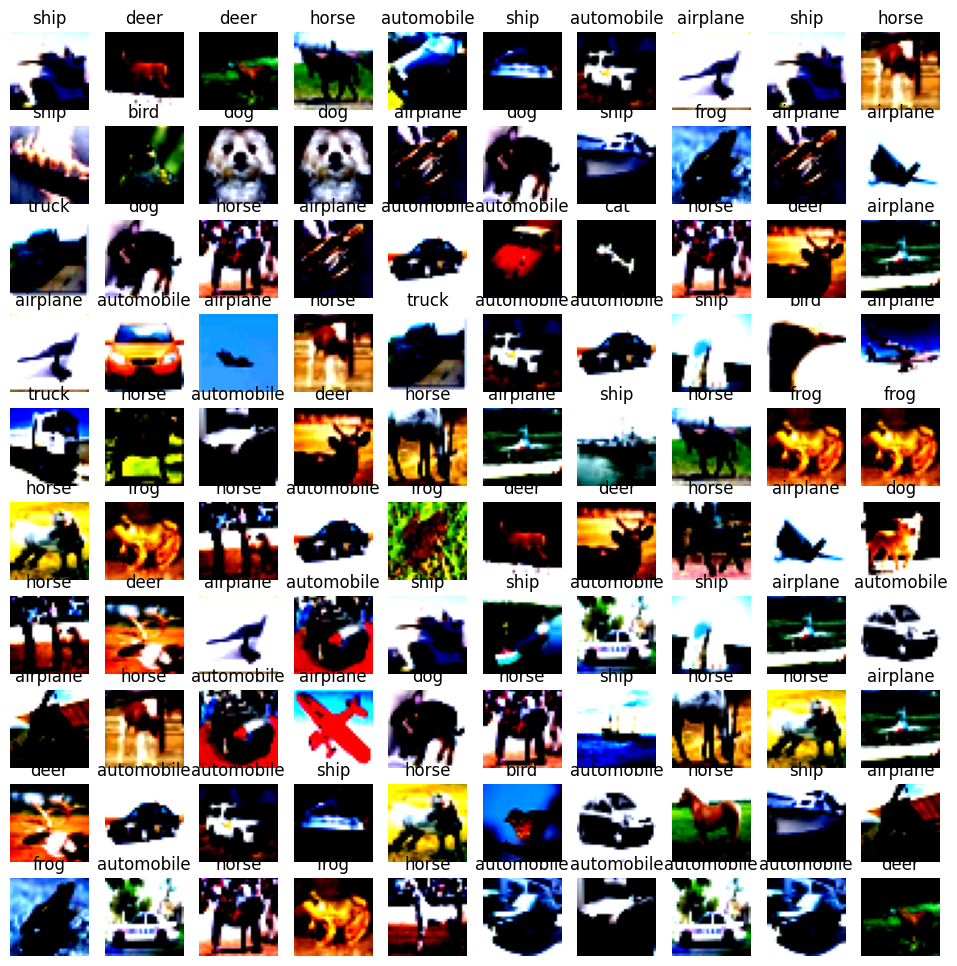

In [6]:
# Obtain the class labels from the CIFAR10 dataset
classes = train_dataset.classes

# Define a function to display a grid of sample images along with their labels
def display_sample(sample_images, sample_labels):
    # Set a fixed seed for reproducibility
    torch.manual_seed(42)
    # Create a figure with a specified size
    fig = plt.figure(figsize=(12, 12))
    # Define the number of rows and columns for the subplot grid
    rows, cols = 10, 10

    # Randomly select indices for a grid of images
    sample_indices = torch.randint(0, len(sample_images), size=(rows * cols,))

    # Loop through each index to plot the image and its label
    for i, idx in enumerate(sample_indices):
        img = sample_images[idx]  # Get the image at the selected index
        img=img.transpose((1,2,0))
        label = sample_labels[idx]  # Get the corresponding label
        ax = fig.add_subplot(rows, cols, i + 1)  # Add a subplot at the correct position
        ax.imshow(img)  # Display the image
        ax.set_title(classes[label.item()]) # Set the title of the subplot to the label's name
        plt.axis('off')  # Hide the axis

    # Show the plot with all images
    plt.show()
    # Close the plot to free up memory
    plt.close()

# Display a sample of images
data_iter = iter(train_loader)  # Create an iterator over the training data
images, labels = next(data_iter)  # Get the next batch of images and labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')  # Print the shape of the images and labels
display_sample(images.cpu().numpy(), labels.cpu().numpy())  # Display the sample images and labels


# **Part 2**. Implement Building Blocks for ResNet


- In ResNet, residual networks are implemented using the following two methods. The first is the Identity method, which uses a simple structure, as shown in the figure below. The second is the Projection method, which scales the dimensions through 1x1 convolution operations to reduce the number of parameters.

  <img src="https://drive.google.com/uc?export=view&id=16QzhXGKVS2XVxDf-5Nz-PZjQRL0dyntO" width="600" height="300" />

- In **Part 2**, we will implement the two types of blocks used in ResNet, the basic block and the bottleneck block.

## **Step 1**. Implement BasicBlock class

This class implements a basic building block for the Residual Network (ResNet) architecture. ResNet's design incorporates "shortcut" or "skip connections" to allow the gradient to be directly backpropagated through the network, addressing the vanishing/exploding gradient problem found in deeper networks. Each `BasicBlock` represents a residual block with two convolutional layers and a skip connection.

&nbsp;

 As can be seen in the following diagram, the BasicBlock consists of following elements:

```
(A 3x3 convolution that returns a vector of dimensions out_channels)
 ➡ (batch normalization)
 ➡ (relu)
 ➡ (A 3x3 convolution that returns a vector of dimensions out_channels)
 ➡ (batch normalization)
 ➡ residual with input vector
 ➡ relu
```

&nbsp;




In [7]:
class BasicBlock(nn.Module):
    """
    Implements a BasicBlock architecture.

    Attributes:
    -----------
    expansion : int
        Class attribute representing the expansion factor for the block's output channels. For
        `BasicBlock`, this is always 1 as there is no expansion within the block itself.

    conv1 : nn.Conv2d
        The first convolutional layer in the block, applying filters to the input data with a
        kernel size of 3x3. The stride can be adjusted, affecting the output's height and width
        and serving as a mechanism for spatial down-sampling. This layer does not use bias.

    bn1 : nn.BatchNorm2d
        Batch Normalization for stabilizing the inputs to the second layer by adjusting and
        scaling the activations. Applied to the outputs of `conv1`.

    relu1 : nn.ReLU
        ReLU activation function applied after first batch normalization, introducing
        non-linearity and enhancing the network's learning capabilities.

    conv2 : nn.Conv2d
        The second convolutional layer with the same kernel size as `conv1` but with a fixed
        stride of 1, preserving the spatial dimensions of the data. This layer also does not use bias.

    bn2 : nn.BatchNorm2d
        Similar to `bn1`, this Batch Normalization layer normalizes the output from `conv2`,
        ensuring that the network remains stable during training.

    shortcut : nn.Sequential
        The skip connection providing a pathway for the original input to bypass the convolutional
        layers, facilitating the gradient flow during backpropagation. If the input and output dimensions
        are consistent, this remains an empty sequential block. If they differ (often due to a change
        in stride), this pathway adjusts the input's dimensions to match the output using a 1x1 convolution.

    Methods:
    --------
    __init__(self, input_channels: int, output_channels: int, stride: int = 1) -> None:
        Constructs all the necessary attributes for the BasicBlock object, including the convolutional
        layers, batch normalization, and the shortcut connection.

    forward(self, x: Tensor) -> Tensor:
        Defines the computation performed at every call, applying both convolutional layers to the input,
        then combining the output with the original input (the "shortcut") before returning the
        final activated result. This method is crucial for the 'torch.nn.Module' interface, as it handles
        the block's operations on input data.
    """

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # Define the first convolutional layer and batch normalization.

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        # Define the second convolutional layer and batch normalization.
        # The number of output channels remains the same as the first layer.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define a shortcut layer that appropriately transforms the input to be added to the transformed feature map up to this point.
        # If input and output are the same dimensions, use an empty sequential model.
        # If the dimensions are different, adjust the layers accordingly using 1x1 convolution + batch normalization.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels*self.expansion:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size = 1,stride = stride, bias = False),
              nn.BatchNorm2d(out_channels)
          )
          # equivalent of;
          # if self.downsample is not None:
          #   identity = self.downsample(identity)


    def forward(self, x):
        # Save the original input for the shortcut connection.
      identity = self.shortcut(x)

      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.conv2(out)
      out = self.bn2(out)

      out += identity
      out = self.relu(out)
      return out

## **Step 2**. Implement Bottleneck block

This class implements the "Bottleneck" building block used in deeper Residual Network (ResNet) architectures. These blocks are designed with efficiency in mind, providing a more efficient way of increasing the depth of the network without a significant increase in computational complexity. The main feature of a Bottleneck block is the use of 1x1 convolutions to reduce and subsequently restore dimensions, ensuring that the 3x3 convolution has a minimal computational load.

&nbsp;

 As can be seen in the following diagram, the Bottleneck class consists of following elements:

```
(A 1x1 convolution that returns a vector of dimensions out_channels)
 ➡ (batch normalization)
 ➡ (relu)
 ➡ (A 3x3 convolution that returns a vector of dimensions out_channels)
 ➡ (batch normalization)
 ➡ (relu)
 ➡ (A 1x1 convolution that returns a vector of dimensions out_channels*4)
 ➡ (batch normalization)
 ➡ residual with input vector
 ➡ relu
```



In [8]:
class Bottleneck(nn.Module):

    """
    Implements a Bottleneck architecture.

    Attributes:
    -----------
    expansion : int
        Class attribute representing the expansion factor for the output channels at the end of
        the block. This attribute multiplies the number of channels in the block, typically
        increasing the depth by 4 times in a standard Bottleneck block.

    conv1 : nn.Conv2d
        The first layer in the bottleneck, a 1x1 convolution. This layer reduces the number of
        channels, preparing the input for the next 3x3 convolution. It is designed without a bias term.

    bn1 : nn.BatchNorm2d
        Batch Normalization for the first convolution, stabilizing the activations and improving
        the training process.

    relu1 : nn.ReLU
        ReLU activation function applied after first batch normalization, introducing
        non-linearity and enhancing the network's learning capabilities.

    conv2 : nn.Conv2d
        The central layer of the bottleneck, a 3x3 convolution. This layer maintains the number
        of channels but can alter the spatial dimensions based on the stride. It is also designed
        without a bias term.

    bn2 : nn.BatchNorm2d
        Batch Normalization for the central convolutional layer, providing the same benefits as `bn1`.

    relu2 : nn.ReLU
        ReLU activation function applied after central batch normalization.

    conv3 : nn.Conv2d
        The final layer in the bottleneck, a 1x1 convolution. This layer expands the number of
        channels by the factor defined in `expansion`, increasing the depth of the feature map.
        This convolution is also without a bias term.

    bn3 : nn.BatchNorm2d
        Batch Normalization for the final convolution, ensuring the network's stability as the depth increases.

    shortcut : nn.Sequential
        A sequential container for the 'shortcut' or 'skip connection'. When the input and output
        dimensions differ, due to either a stride not equal to 1 or a difference in the number of channels,
        this pathway contains a 1x1 convolution that adjusts the input's dimensions to match the output.

    Methods:
    --------
    __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        Initializes the Bottleneck block with its convolutional layers, batch normalization,
        and prepares the shortcut connection.

    forward(self, x: Tensor) -> Tensor:
        Defines the computation performed at every call. The input passes through each layer of the
        bottleneck, with a skip connection adding the input of the block to its output. This method
        applies the ReLU activation function after each addition and finally returns the resulting tensor.
    """

    # This value is used to adjust the number of output channels in the layer, e.g., out_channels * expansion.
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        # Define the first 1x1 convolution layer.
        # It should take in_channels and return out_channels.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        # Define the second 3x3 convolution layer.
        # It should take out_channels and return out_channels, possibly performing downsampling using stride and padding.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)


        # Define the third 1x1 convolution layer.
        # It should take out_channels and return out_channels * expansion.
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # Shortcut definition for skip connection

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )



    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(identity)

        out = self.relu1(out)
        return out  # Return the final output


# **Part 3**. Implement variants of ResNet
-

  <img src="https://drive.google.com/uc?export=view&id=1lY6jHixjUNKYpiw0Nho0XyLzlHuvhmGh" width="700" height="330" />
  
- First, we will implement a common ResNet class that can be used to build variants of ResNet, and through this, we will create each model.

## **Step 1**. Implement ResNet Class



In [9]:
class ResNet(nn.Module):
      """
      Implements a Residual Network (ResNet) architecture.

      The ResNet architecture is designed with deep residual learning to ease the training of
      networks that are substantially deeper than those used previously. This class creates a
      customizable ResNet model by stacking layers of residual blocks, performing initial
      convolution, and final classification using a fully connected layer.

      Attributes:
      -----------
      in_channels : int
          The number of channels in the input data. Initialized to 64 for the first layer.
      conv1 : nn.Conv2d
          The first convolutional layer which applies 64 filters with a 7x7 kernel, stride of 2,
          and padding of 3.
      bn1 : nn.BatchNorm2d
          Batch Normalization for the first convolutional layer.
      relu : nn.ReLU
          ReLU activation function used after batch normalization.
      maxpool : nn.MaxPool2d
          Max pooling with a 3x3 kernel, stride of 2, and padding of 1.
      layer1-4 : nn.Sequential
          Layers of residual blocks, with the number of blocks and output channels varying
          per layer. Each individual layer is created by the _make_layer private method.
      linear : nn.Linear
          The final fully connected layer that outputs the classification results.

      Methods:
      --------
      __init__(self, block, num_blocks, num_classes=10):
          Initializes the ResNet with the given block type, list of integers representing the
          number of blocks in each layer, and the number of classification classes.

      _make_layer(self, block, output_channels, num_blocks, stride):
          Helper function to create a layer of residual blocks with the specified number of blocks,
          output channels, and the initial stride.

      forward(self, x):
          Defines the forward pass of the input through the ResNet architecture. The input data 'x'
          passes sequentially through the initial convolution (with batch normalization and ReLU),
          max pooling, four residual layers, and finally, the fully connected layer for classification.
          The output of this method is the classification result of the input.
      """

      def __init__(self, block, num_blocks, num_classes=10):
          super(ResNet, self).__init__()
          self.in_channels = 64  # Starting number of channels

          # Define the initial convolutional layer and batch normalization.
          self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
          self.bn1 = nn.BatchNorm2d(self.in_channels)
          self.relu = nn.ReLU(inplace=True)
          self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

          # Define layers consisting of BasicBlocks. Each layer may contain multiple blocks.
          # The number of blocks for each layer is specified in num_blocks.
          # Define the four layers of the ResNet (self.layer1 to self.layer4) using the '_make_layer' function.
          self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
          self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
          self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
          self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

          self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

          # Define the final fully connected layer that maps the output of the convolutional layers to the classes.
          self.linear = nn.Linear(512 * block.expansion, num_classes)

      def _make_layer(self, block, out_channels, num_blocks, stride):
          # This function creates a sequential layer for each set of blocks.

          strides = [stride] + [1]*(num_blocks-1)  # First block stride, and 1 for the rest
          layers = []
          for stride in strides:
              layers.append(block(self.in_channels, out_channels, stride))
              self.in_channels = out_channels * block.expansion
          return nn.Sequential(*layers)


      def forward(self, x):
          # Define the forward pass through the ResNet architecture.
          out = self.conv1(x)
          out = self.bn1(out)
          out = self.relu(out)
          out = self.maxpool(out)

          out = self.layer1(out)
          out = self.layer2(out)
          out = self.layer3(out)
          out = self.layer4(out)

          out = self.avgpool(out)
          out = torch.flatten(out, 1)
          out = self.linear(out)

          return out

## **Step 2 **. Construct and check your ResNet1 variants

In [10]:
# Define the ResNet models using the previously defined BasicBlock and ResNet class.

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

# Instantiate the ResNet models
model1 = ResNet18(num_classes=10)
model2 = ResNet34(num_classes=10)
model3 = ResNet50(num_classes=10)
model4= ResNet101(num_classes=10)
model5 = ResNet152(num_classes=10)

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model2.to(device)
model3.to(device)
model4.to(device)
model5.to(device)
print('models___')
# # Print model summaries
# summary(model1, (64, 28, 28))
# summary(model2, (64, 28, 28))
# summary(model3, (64, 28, 28))
# summary(model4, (64, 28, 28))
# summary(model5, (64, 28, 28))


models___


# **Part 4**. Train and visualize the results

In [11]:
# Define transformations for the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 training and validation datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_train)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
import torch.optim as optim
from tqdm import tqdm
def train_model(model,train_loader,criterion,optimizer,device,num_epochs):
    model.train()
    for epoch in range(num_epochs):
      running_loss=0.0
      for i, (inputs,labels) in tqdm(enumerate(train_loader)):
        inputs,labels=inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
      print(f'[Epoch{epoch+1}] loss: {running_loss/len(train_loader):.3f}')
    print('Finished Training')

def validate_model(model,val_loader,criterion,device):
    model.eval()
    correct=0
    total=0
    val_loss=0.0
    with torch.no_grad():
      for inputs,labels in val_loader:
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        val_loss=loss.item()
        _, predicted=torch.max(outputs.data,1) # find the class with highest predicted score for each input in the batch
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    accuracy=(correct/total)*100
    print(f'accuracy: {accuracy:.2f}% | loss:{val_loss/len(val_loader):.3f}')
    return accuracy

# Train with ResNet18--> the shallowest

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer1=optim.Adam(model1.parameters(),lr=0.001,weight_decay=5e-4)
train_model(model1,train_loader,criterion,optimizer1,device,num_epochs=10)
print("accuracy on train_set")
validate_model(model1,train_loader,criterion,device)
print("accuracy on val_set")
validate_model(model1,val_loader,criterion,device)


46it [01:17,  1.56s/it]

# Train with ResNet50--> the deepest

In [36]:
criterion=nn.CrossEntropyLoss()
optimizer1=optim.SGD(model2.parameters(),lr=0.001,momentum=0.9,weight_decay=5e-4)
train_model(model4,train_loader,criterion,optimizer1,device,num_epochs=20)
validate_model(model1,val_loader,criterion,device)
#

[Epoch1,Batch100] loss: 1.388
[Epoch1,Batch200] loss: 1.382
[Epoch1,Batch300] loss: 1.398
[Epoch2,Batch100] loss: 1.396
[Epoch2,Batch200] loss: 1.384
[Epoch2,Batch300] loss: 1.387
[Epoch3,Batch100] loss: 1.392
[Epoch3,Batch200] loss: 1.402
[Epoch3,Batch300] loss: 1.379
[Epoch4,Batch100] loss: 1.386
[Epoch4,Batch200] loss: 1.383
[Epoch4,Batch300] loss: 1.407
[Epoch5,Batch100] loss: 1.408
[Epoch5,Batch200] loss: 1.365
[Epoch5,Batch300] loss: 1.403
[Epoch6,Batch100] loss: 1.374
[Epoch6,Batch200] loss: 1.394
[Epoch6,Batch300] loss: 1.384
[Epoch7,Batch100] loss: 1.408
[Epoch7,Batch200] loss: 1.394
[Epoch7,Batch300] loss: 1.401
[Epoch8,Batch100] loss: 1.378
[Epoch8,Batch200] loss: 1.377
[Epoch8,Batch300] loss: 1.391
[Epoch9,Batch100] loss: 1.418
[Epoch9,Batch200] loss: 1.375
[Epoch9,Batch300] loss: 1.397
[Epoch10,Batch100] loss: 1.393
[Epoch10,Batch200] loss: 1.396
[Epoch10,Batch300] loss: 1.400
[Epoch11,Batch100] loss: 1.387
[Epoch11,Batch200] loss: 1.398
[Epoch11,Batch300] loss: 1.380
[Epo

83.24000000000001

# Generate meta features-for stacking- from the trained models by predicting on the validation set

In [ ]:
def get_meta_features(models,val_loader,device):
  meta_features=[]
  for model in models:
    model.eval()
    pred=[]
    with torch.no_grad():
      for _,inputs in val_loader:

        inputs=inputs.device()
        outputs=model(inputs)
        preds.append(output.cpu().numpy())
    meta_features.append(np.vstack(preds))

  retrun np.hstack(meat_features) # stack meta featurs horizontally: each model's predictions side by side

models=[model1,model2]
meta_features=get_meta_features(models,val_loader,device)   # generate meat features
meta_targets=np.array([label for _,label in val_loader.dataset])  # extract true labels


# Train the meta-model on the generated meta-features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# train the logistic regression on meta-features
meta_model=LogisticRegression(max_iter=1000)
meta_model.fit(meta_features,meta_targets)

#